In [1]:
import torch as T
import torch
import torch.nn.functional as F
import torch.nn as nn
from torchvision.utils import save_image
from torch.utils.data import DataLoader, Dataset
import scipy.linalg
from functools import partial
%pylab
%matplotlib inline
import matplotlib as mpl
import matplotlib.gridspec as gridspec
import scipy.sparse as sparse
from scipy import stats
from __future__ import print_function
import gc
from tqdm import tqdm_notebook as tqdm
from __future__ import division
import pandas as pd
import seaborn as sb
import os
from pandas import DataFrame
from scipy.spatial import distance
from scipy.cluster import hierarchy
from torchvision.transforms import Resize
import dill
from joblib import Parallel, delayed
import cv2
import resource
import apex # https://github.com/NVIDIA/apex.git
from apex.amp import amp

import os, sys, datetime
LF_CODE_PATH = os.path.expanduser('~/projects/LFAnalyze/code')
FT_CODE_PATH = os.path.expanduser('~/projects/fishTrax/code/analysis/')
FD_CODE_PATH = os.path.expanduser('~/projects/fish_despair_notebooks/src/')
sys.path.insert(0,LF_CODE_PATH)
sys.path.insert(0,FT_CODE_PATH)
sys.path.insert(0,FD_CODE_PATH)

import passivity_2p_imaging_utils as p2putils
reload(p2putils)
tmp_dir = '/tmp/'
all_data = p2putils.get_all_datasets(tmp_dir=tmp_dir)

/home/ubuntu/anaconda3/envs/pytorch_p27/lib/python2.7/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/pytorch_p27/lib/python2.7/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


Using matplotlib backend: agg
Populating the interactive namespace from numpy and matplotlib


/home/ubuntu/anaconda3/envs/pytorch_p27/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
torch.backends.cudnn.benchmark = True

In [3]:
gen = False
# gen = True
cuda=True
half=True
half=False

# if not gen:
#     f = all_data['e'][2]

# time_fish = T.from_numpy(f.frame_st.mean(1).astype(np.float32)).cuda()
# u_fish = T.cuda.FloatTensor(time_fish.shape).zero_()
# p_fish = T.cuda.FloatTensor(time_fish.shape).zero_()
# u_fish[numpy.searchsorted(f.frame_et[:,-1], f.shock_st,side="left")] = 1

In [4]:
import subprocess

def get_gpu_memory_map():
    """Get the current gpu usage.

    Returns
    -------
    usage: dict
        Keys are device ids as integers.
        Values are memory usage as integers in MB.
    """
    result = subprocess.check_output(
        [
            'nvidia-smi', '--query-gpu=memory.used',
            '--format=csv,nounits,noheader'
        ])
    # Convert lines into a dictionary
    gpu_memory = [int(x) for x in result.strip().split('\n')]
    gpu_memory_map = dict(zip(range(len(gpu_memory)), gpu_memory))
    return gpu_memory_map

In [5]:
def get_frames_from_z(z, fish,half=False):
    tiff = fish.get_tif_rasl(z)
    ntime = fish.frame_et.shape[0]
    if half:
        dtype = np.float16
    else:
        dtype = np.float32
    frames = np.zeros((ntime, tiff.frame_shape[0],tiff.frame_shape[1])).astype(dtype)
    for t in range(ntime):
        frame = np.array(tiff.get_frame(t)).astype(dtype)
        frames[t] = frame
    return frames

def get_imaging_from_fish(f,n_jobs=8, half=False):
    nZ = f.num_zplanes
    if half:
        dtype = np.float16
    else:
        dtype = np.float32
    # frames_by_z = pool.map(partial(get_frames_from_z, fish=f), range(nZ))
    frames_by_z = Parallel(n_jobs=n_jobs)(delayed(get_frames_from_z)(z,fish=f) for z in range(nZ))
    imaging = np.stack(frames_by_z).swapaxes(0,1).astype(dtype)
    return imaging

def gen_imaging(nT, nZ, H, W, half=False):
    if half:
        dtype = np.float16
    else:
        dtype = np.float32
    return np.random.randint(0,3000,[nT,nZ,H,W]).astype(dtype)

In [6]:
def resize_volume(images, fx, fy, interpolation=cv2.INTER_CUBIC):
    im = cv2.resize(images[0], None, fx=fx, fy=fy, interpolation=interpolation)
    new = np.zeros([images.shape[0],im.shape[0],im.shape[1]]).astype(np.float32)
    new[0] = im
    for i, img in enumerate(images[1:]):
        new[i] = cv2.resize(img, None, fx=fx, fy=fy, interpolation=interpolation)
    return new

def resize_batch(images, fx, fy, interpolation=cv2.INTER_CUBIC):
    im = cv2.resize(images[0,0], None, fx=fx, fy=fy, interpolation=interpolation)
    new = np.zeros([images.shape[0],images.shape[1], im.shape[0],im.shape[1]]).astype(np.float32)
    for b, vol in enumerate(images):
        for z, img in enumerate(vol):
            new[b,z] = cv2.resize(img, None, fx=fx, fy=fy, interpolation=interpolation)
    return new

In [7]:
def resize_volume(images, fx, fy, interpolation=cv2.INTER_CUBIC):
    im = cv2.resize(images[0], None, fx=fx, fy=fy, interpolation=interpolation)
    new = np.zeros([images.shape[0],im.shape[0],im.shape[1]]).astype(np.float32)
    new[0] = im
    for i, img in enumerate(images[1:]):
        new[i] = cv2.resize(img, None, fx=fx, fy=fy, interpolation=interpolation)
    return new

def resize_batch(images, fx, fy, interpolation=cv2.INTER_CUBIC):
    im = cv2.resize(images[0,0], None, fx=fx, fy=fy, interpolation=interpolation)
    new = np.zeros([images.shape[0],images.shape[1], im.shape[0],im.shape[1]]).astype(np.float32)
    for b, vol in enumerate(images):
        for z, img in enumerate(vol):
            new[b,z] = cv2.resize(img, None, fx=fx, fy=fy, interpolation=interpolation)
    return new

In [8]:
if gen:
    imaging = gen_imaging(32,11,232,512)
else:
#     imaging = get_imaging_from_fish(f)
# imaging = resize_batch(imaging,0.5,0.5)
# np.savez('/home/ubuntu/f01555.npz',fish=imaging)
# np.savez('/home/ubuntu/f01555_small.npz',fish=imaging)
#     imaging = np.load('/home/ubuntu/f01555.npz')['fish']
    imaging = np.load('/home/ubuntu/f01555_small.npz')['fish']

In [9]:
class FishImageData(Dataset):    
    def __init__(self, imaging):
        data = imaging - imaging.mean(0)
        self.data = T.from_numpy(data)
        
    def __len__(self):
        return self.data.shape[0]-1

    def __getitem__(self, idx):
        return self.data[idx], self.data[idx+1]
    
class FishDiffData(Dataset):    
    def __init__(self, imaging):
        X = imaging - imaging.mean(0)
        self.X = T.from_numpy(X)
        self.Y = T.from_numpy(np.diff(X, axis=0))
        
    def __len__(self):
        return self.Y.shape[0]

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

class FishMultData(Dataset):    
    def __init__(self, imaging, prev_frames=2, next_frames=1):
        data = imaging - imaging.mean(0)
        # use channel for future / prev frames
        self.data = T.from_numpy(data)
        self.prev_frames = prev_frames
        self.next_frames = next_frames
        
    def __len__(self):
        return self.data.shape[0]-self.prev_frames - self.next_frames + 1

    def __getitem__(self, i):
        idx = i + self.prev_frames - 1 # avoid wraparound
        X = []
        Y = []
        for i in reversed(range(self.prev_frames)):
            X.append(self.data[idx-i])
        for i in range(1,self.next_frames+1):
            Y.append(self.data[idx+i])
        X = T.stack(X,1)
        Y = T.stack(Y,1)
        return X, Y

# data = FishImageData(imaging)
# data = FishDiffData(imaging)
prev_frames = 2
next_frames = 2
data = FishMultData(imaging,prev_frames,next_frames)

nZ, _, H, W = data[0][0].shape

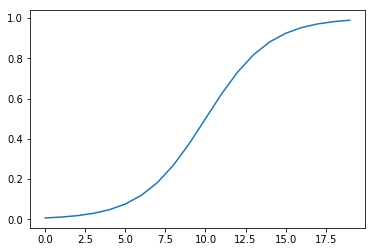

In [10]:
def sigmoid_schedule(t,k=5):
    t0 = t/2
    k = k/t0
    t = np.arange(t)
    return (1/(1+np.exp(-k*(t-t0)))).astype(np.float32)

plt.plot(sigmoid_schedule(20,5))

In [11]:
import torch.nn as nn
import math
import torch.utils.model_zoo as model_zoo



def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(self, block, layers, prev_frames=1):
        self.inplanes = 64
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(prev_frames, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
#         self.layer1 = self._make_layer(block, 64, layers[0], stride=1)
        self.layer1 = self._make_layer(block, 64, layers[0], stride=1) # for full-size images
        self.layer2 = self._make_layer(block, 64, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 64, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 64, layers[3], stride=2)
#         self.avgpool = nn.AvgPool2d(8, stride=1)
#         self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        # 232 x 512
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
#         print(x.shape)
        # 58 x 128

        x = self.layer1(x)
#         print(x.shape)
        # 29 x 64
        x = self.layer2(x)
#         print(x.shape)
        # 15 x 32
        x = self.layer3(x)
#         print(x.shape)
        # 8 x 16
        x = self.layer4(x)
        # 4 x 8
        x = x.view(x.shape[0],-1).mean(1)
        # 1 x 1
#         x = x.view(x.size(0), -1)
#         x = self.fc(x)
        return x[:,None]

In [12]:
def get_padding(padding_type, kernel_size):
    assert padding_type in ['SAME', 'VALID']
    if padding_type == 'SAME':
        return tuple((k - 1) // 2 for k in kernel_size)
    return tuple(0 for _ in kernel_size)


class Vol2D(nn.Module):
    "Use same 2D operations mapped over each z slice"
    def __init__(self, tensor=T.cuda.FloatTensor):
        super(Vol2D, self).__init__()
        self.tensor = tensor
        
    def vol_PixelShuffle(self, x):
        # Helper for subpixel convolution
        first = self.pixel_shuffle(x[:,0])
        # b x z x H x W
        ret = self.tensor(x.shape[0],x.shape[1],first.shape[2], first.shape[3])
        for z in range(x.shape[1]):
            ret[:,z] = self.pixel_shuffle(x[:,z])[:,0]
        return ret
        
        # batch x Z*C x H x W
        input = x.view(x.shape[0],-1,x.shape[3],x.shape[4])
        pooled = F.max_pool2d(input,kernel_size)
        return pooled.reshape(pooled.shape[0],x.shape[1],x.shape[2],pooled.shape[2],pooled.shape[3])
    
    def vol_MaxPool2d(self, x, kernel_size):
        # batch x Z*C x H x W
        input = x.view(x.shape[0],-1,x.shape[3],x.shape[4])
        pooled = F.max_pool2d(input,kernel_size)
        return pooled.reshape(pooled.shape[0],x.shape[1],x.shape[2],pooled.shape[2],pooled.shape[3])
    
    def vol_BatchNorm2d(self, x, bn):
        activations = self.tensor(x.shape)
        for z in range(x.shape[1]):
            activations[:,z] = bn(x[:,z].contiguous())
        return activations
                
    def vol_conv2d(self, x, weight, pad):
        # batch x Z x C x H x W
        activations = self.tensor(x.shape[0],x.shape[1],weight.shape[0],x.shape[3],x.shape[4])
        for z in range(x.shape[1]):
            activations[:,z] = F.conv2d(x[:,z], weight, padding=pad)
        return activations
    
    def crop(self, x):
        cropH = (x.shape[2] - self.H)/2
        cropW = (x.shape[3] - self.W)/2
        if cropH>0:
            x = x[:,:,int(np.floor(cropH)):-int(np.ceil(cropH))]
        if cropW>0:
            x = x[:,:,:,int(np.floor(cropW)):-int(np.ceil(cropW))]
        return x

class SuperResBlock(Vol2D):
    """Upsample Volume using subpixel convolution.
    
    Reference: https://arxiv.org/pdf/1609.05158.pdf"""
    def __init__(self, upscale_factor, tensor):
        super(SuperResBlock, self).__init__(tensor=T.cuda.FloatTensor)
        self.tensor = tensor
        self.activation = nn.ReLU()
        self.dconv1 = nn.Parameter(self.tensor(64,1,5,5))
        self.dpad1 = (2,2)
        self.dbn1 = nn.BatchNorm2d(64)
        self.dconv2 = nn.Parameter(self.tensor(64,64,3,3))
        self.dpad2 = (1,1)
        self.dbn2 = nn.BatchNorm2d(64)
        self.dconv3 = nn.Parameter(self.tensor(32,64,3,3))
        self.dpad3 = (1,1)
        self.dbn3 = nn.BatchNorm2d(32)
        self.dconv4 = nn.Parameter(self.tensor(upscale_factor**2,32,3,3))
        self.dpad4 = (1,1)
        self.pixel_shuffle = nn.PixelShuffle(upscale_factor)
        
        self.initialize_weights()

    def forward(self, x):        
        x = self.activation(self.vol_BatchNorm2d(self.vol_conv2d(x, self.dconv1, self.dpad1), self.dbn1))
        x = self.activation(self.vol_BatchNorm2d(self.vol_conv2d(x, self.dconv2, self.dpad2), self.dbn2))
        x = self.activation(self.vol_BatchNorm2d(self.vol_conv2d(x, self.dconv3, self.dpad3), self.dbn3))
        x = self.vol_conv2d(x, self.dconv4, self.dpad4)
        x = self.vol_PixelShuffle(x)
        # add back single channel
        x = x[:,:,None]
        return x
    
    def initialize_weights(self):
        if self.tensor==T.cuda.FloatTensor:
            nn.init.orthogonal_(self.dconv1, nn.init.calculate_gain('relu'))
            nn.init.orthogonal_(self.dconv2, nn.init.calculate_gain('relu'))
            nn.init.orthogonal_(self.dconv3, nn.init.calculate_gain('relu'))
            nn.init.orthogonal_(self.dconv4)
        else:
            for m in [self.dconv1, self.dconv2, self.dconv3, self.dconv4]:
                nn.init.kaiming_normal_(m, mode='fan_out', nonlinearity='relu')
        for bn in [self.dbn1,self.dbn2,self.dbn3]:
            nn.init.constant_(bn.weight, 1)
            nn.init.constant_(bn.bias, 0)
    

In [13]:
class tofp16(nn.Module):
    """
    Model wrapper that implements::
        def forward(self, input):
            return input.half()
    """

    def __init__(self):
        super(tofp16, self).__init__()

    def forward(self, input):
        return input.cuda().half()


def BN_convert_float(module):
    '''
    Designed to work with network_to_half.
    BatchNorm layers need parameters in single precision.
    Find all layers and convert them back to float. This can't
    be done with built in .apply as that function will apply
    fn to all modules, parameters, and buffers. Thus we wouldn't
    be able to guard the float conversion based on the module type.
    '''
    if isinstance(module, torch.nn.modules.batchnorm._BatchNorm):
        module.float()
    for child in module.children():
        BN_convert_float(child)
    return module


def network_to_half(network):
    """
    Convert model to half precision in a batchnorm-safe way.
    """
    return nn.Sequential(tofp16(), BN_convert_float(network.half()))

In [14]:
class Conv(Vol2D):
    def __init__(self, nZ=11, H=232, W=512, nEmbedding=20, prev_frames=1,
                 tensor=T.cuda.FloatTensor):
        super(Conv, self).__init__(tensor)
        self.tensor = tensor
        self.nZ = nZ
        self.H = H
        self.W = W
        self.lowH = 8
        self.lowW = 16
        self.lowFeatures = 1
        # batch x channel x Z x H x W
        # Encoding
        self.resnet = ResNet(BasicBlock, [2, 2, 2, 2], prev_frames)
        self.resOut = 1
        
        # b x 11 x 32 x 11 x 25
        self.encoding_mean = nn.Linear(self.resOut*self.nZ, nEmbedding)
        self.encoding_logvar = nn.Linear(self.resOut*self.nZ, nEmbedding)
        
        # Prediction
        self.pred1 = nn.Linear(nEmbedding, nEmbedding)
        self.pred2 = nn.Linear(nEmbedding, nEmbedding)
        self.pred_bn1 = nn.BatchNorm1d(nEmbedding)
        
        # Decoding
        self.activation = nn.Tanh() # change on Jul 9
#         self.activation = nn.ReLU()
        self.decoding = nn.Linear(nEmbedding,self.lowFeatures*nZ*self.lowH*self.lowW)
        self.upconv1 = SuperResBlock(2,tensor)
        # 11 x 16 x 32
        self.upconv2 = SuperResBlock(2,tensor)
        # 11 x 32 x 64
        self.upconv3 = SuperResBlock(2,tensor)
        # 11 x 64 x 128
        self.upconv4 = SuperResBlock(2,tensor)
        # 11 x 128 x 256
#         self.upconv5 = SuperResBlock(2,tensor)
        # 11 x 256 x 512
        
        self._initialize_weights()
        
    def _initialize_weights(self):
        nn.init.xavier_normal_(self.encoding_mean.weight)
        # TODO - make larger?
        nn.init.xavier_normal_(self.encoding_logvar.weight,1e-3)
    
    def sample_embedding(self, mu, logvar):
        if self.training:
            # during training so far, had this implementation which lowers logvar (until Jul 7, 2018)
#             std = torch.exp(0.1*logvar)
#             dist = T.distributions.normal.Normal(T.zeros_like(std),T.ones_like(std))
#             std_z = dist.sample()
#             return mu + std*std_z
            std = torch.exp(0.5*logvar)
            eps = torch.randn_like(std)
            return eps.mul(std).add_(mu)
        else:
            return mu
    
    def encode(self, x):
        out = self.tensor(x.shape[0],x.shape[1],self.resOut)
        for z in range(x.shape[1]):
            out[:,z] = self.resnet(x[:,z])
        mean = self.encoding_mean(out.reshape(x.shape[0],-1))
        logvar = self.encoding_logvar(out.reshape(x.shape[0],-1))
        return mean, logvar
     
    def predict(self, x):
        x = self.activation(self.pred1(x))
        x = self.pred2(x)
        return x
        
    def decode(self, x):
        # b x 20
        x = self.activation(self.decoding(x))
        x = x.reshape(x.shape[0],self.nZ,self.lowFeatures,self.lowH,self.lowW)
        x = self.upconv1(x)
        x = self.upconv2(x)
        x = self.upconv3(x)
        x = self.upconv4(x)
#         x = self.upconv5(x)
        x = self.crop(x[:,:,0])
        # squeeze channel
        return x

    def forward(self, x):
        "Return Previous volume (denoised), next volume (prediction), latent mean and logvar."
        mean, logvar = self.encode(x)
        encoded = self.sample_embedding(mean, logvar)
        encoded_pred = self.predict(encoded)
        prev = self.decode(encoded)
        pred = self.decode(encoded_pred)
        return prev, pred, mean, logvar

    
def unit_norm_KL_divergence(mu, logvar):
    "Reconstruction + KL divergence losses summed over all elements and batch."
    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    return -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())


def train(model,data,nepochs=10, lr=1e-3, half=False, cuda=True):
    dataloader = DataLoader(data, batch_size=batch_size, shuffle=True)
    kl_schedule = T.from_numpy(sigmoid_schedule(nepochs))
    if half:
        optimizer = apex.fp16_utils.FP16_Optimizer(T.optim.Adam(model.parameters(),lr=lr))
    else:
        optimizer = T.optim.Adam(model.parameters(),lr=lr)
        
    if cuda:
        kl_schedule = kl_schedule.cuda()
    for e in range(nepochs):
        print("epoch {}: ".format(e), end="")
        cum_loss = 0
        cum_X_loss = 0
        cum_Y_loss = 0
        for batch_data in tqdm(dataloader):
            X, Y = batch_data
            # add 1 channel
            if cuda:
                # half will alrea
                X = X.cuda()
                Y = Y.cuda()
            X_pred, Y_pred, mean, logvar = model(X)
            if half:
                X_pred = X_pred.float()
                Y_pred = Y_pred.float()
                mean = mean.float()
                logvar = logvar.float()
            kld = unit_norm_KL_divergence(mean, logvar)
            if np.random.rand()>0.5:
                mse_X = F.mse_loss(X_pred, X[:,:,0], size_average=False)
            else:
                mse_X = F.mse_loss(X_pred, X[:,:,1], size_average=False)
            if np.random.rand()>0.5:
                mse_Y = F.mse_loss(Y_pred, Y[:,:,0], size_average=False)
            else:
                mse_Y = F.mse_loss(Y_pred, Y[:,:,1], size_average=False)
            loss = mse_X + mse_Y + kl_schedule[e] * kld
#             if e==0:
#                 print("MSE_X: {:.3E}, MSE_Y: {:.3E}, KLD: {:.3E}".format(float(mse_X),float(mse_Y),float(kld)))
            optimizer.zero_grad()
            if half:
                optimizer.backward(loss)
            else:
                loss.backward()
            optimizer.step()
            cum_loss += float(loss)
            cum_X_loss += float(mse_X)
            cum_Y_loss += float(mse_Y)

        print("avg_loss: {:3E}, X_loss: {:3E}, Y_loss: {:3E}".format(
            cum_loss/len(data), cum_X_loss/len(data), cum_Y_loss/len(data)))        

nEmbedding = 10
batch_size = 20
tensorlib = T
if cuda:
    tensorlib = T.cuda

if half:
    tensor = tensorlib.HalfTensor
else:
    tensor = tensorlib.FloatTensor

conv_model = Conv(nZ,H,W,nEmbedding,prev_frames,tensor=tensor)
if cuda:
    conv_model.cuda()
if half:
    conv_model = apex.fp16_utils.network_to_half(conv_model)
print("total num params:", np.sum([np.prod(x.shape) for x in conv_model.parameters()]))
# conv_model(data[0][0][None,:,None].cuda()).shape

total num params: 860384


In [ ]:
train(conv_model,data,100,lr=1e-3, half=half, cuda=cuda)
# 1.91E+02

epoch 0: 


avg_loss: 1.660895E+09, X_loss: 8.304636E+08, Y_loss: 8.304317E+08
epoch 1: 

In [23]:
model_name = "180711_small_X2_Y2_X:5.89E+08_Y:5.90E+08"

In [24]:
T.save(conv_model.state_dict(),model_name+".pt")

conv_model.load_state_dict(T.load(model_name+".pt"))

In [25]:
def volume_mse(X, Y):
    with T.no_grad():
        loss = F.mse_loss(X,Y,reduce=False).reshape(X.shape[0],-1).sum(1)
    return loss

In [26]:
def prediction_quality(model,data, batch_size=96):
    dataloader = DataLoader(data, batch_size=batch_size, shuffle=False)
    size = len(data)
    with T.no_grad():
        time = np.random.randint(len(data))
        z = np.random.randint(nZ)
        mse_X = 0
        mse_X_pred_to_Y = 0
        mse_Y_pred_to_X = 0
        mse_Y = 0
        for batch_data in tqdm(dataloader):
            X, Y = batch_data
            X = X.cuda()
            Y = Y.cuda()
            X_pred, Y_pred, _, _ = model(X)
            mse_X += float(volume_mse(X_pred,X[:,:,-1]).cpu().sum())
            mse_X_pred_to_Y += float(volume_mse(X_pred,Y[:,:,0]).cpu().sum())
            mse_Y_pred_to_X += float(volume_mse(Y_pred,X[:,:,-1]).cpu().sum())
            mse_Y += float(volume_mse(Y_pred,Y[:,:,0]).cpu().sum())
        return mse_X/size, mse_X_pred_to_Y/size, mse_Y_pred_to_X/size, mse_Y/size

pred_quality = prediction_quality(conv_model, data)
print("MSE(X_pred,X)={:.4g}, MSE(X_pred,Y)={:.4g}\nMSE(Y_pred,Y)={:.4g}, MSE(Y_pred,X)={:.4g}".format(*pred_quality))


MSE(X_pred,X)=7.097e+08, MSE(X_pred,Y)=7.102e+08
MSE(Y_pred,Y)=6.995e+08, MSE(Y_pred,X)=6.993e+08


/home/ubuntu/anaconda3/envs/pytorch_p27/lib/python2.7/site-packages/ipykernel/__main__.py:19: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/home/ubuntu/anaconda3/envs/pytorch_p27/lib/python2.7/site-packages/ipykernel/__main__.py:19: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/home/ubuntu/anaconda3/envs/pytorch_p27/lib/python2.7/site-packages/ipykernel/__main__.py:19: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/home/ubuntu/anaconda3/envs/pytorch_p27/lib/python2.7/site-packages/ipykernel/__main__.py:20: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/home/ubuntu/anaconda3/envs/pytorch_

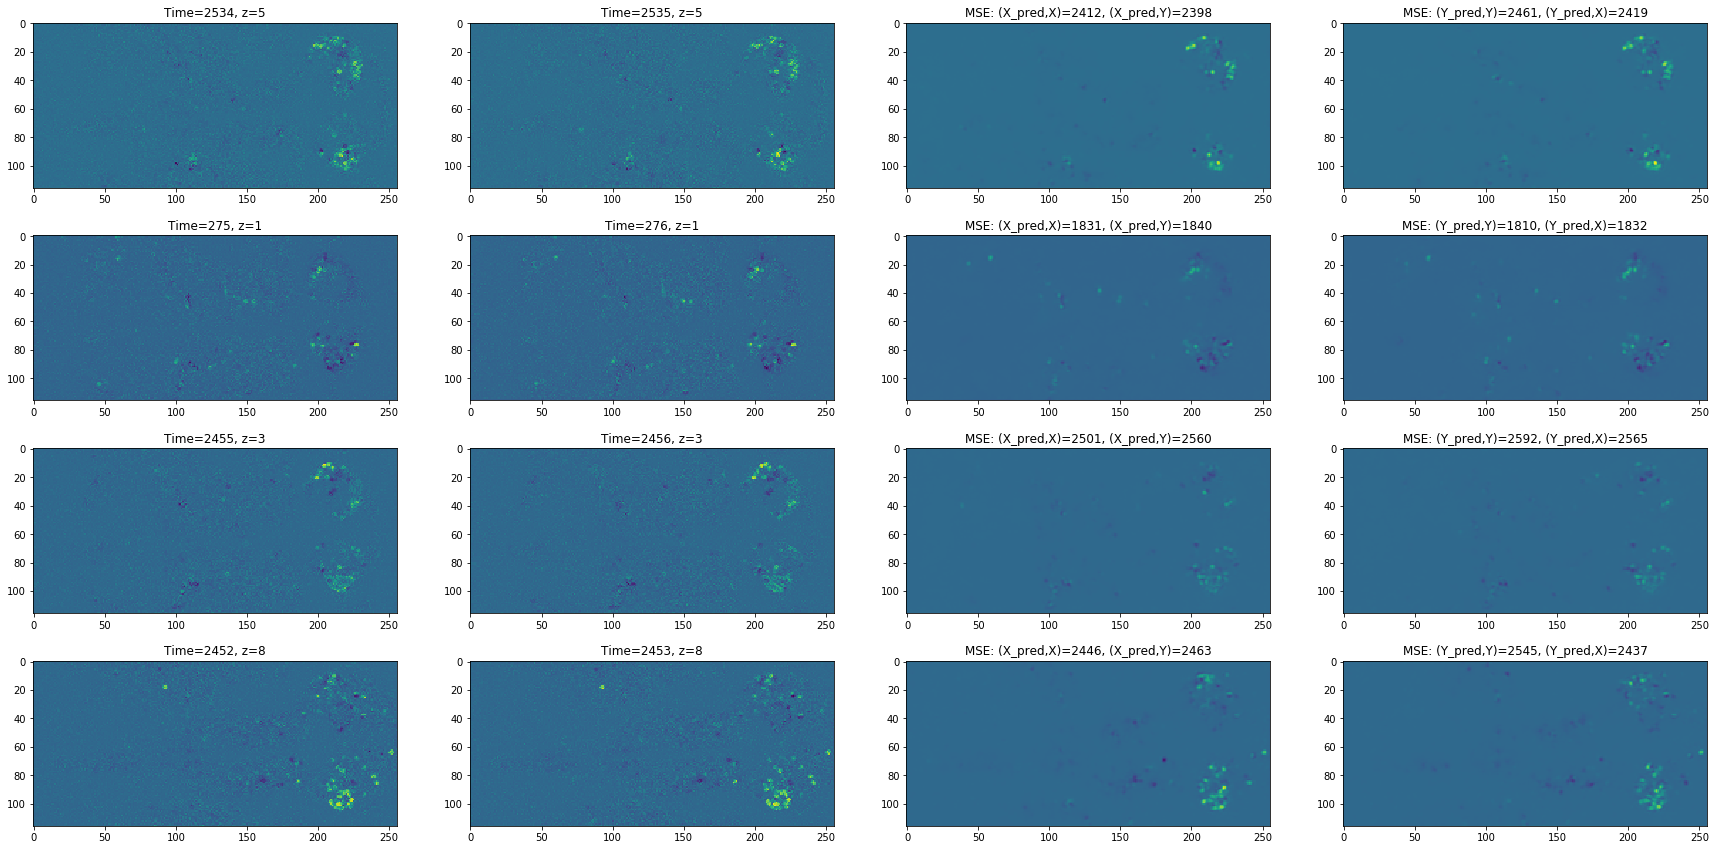

In [27]:
def plot_model_vs_real(model,data):
    plt.figure(figsize=(30,15))

    with T.no_grad():
        for i in range(4):
            time = np.random.randint(len(data))
            z = np.random.randint(nZ)
            X, Y = data[time]
            x = X[None].cuda()
            y = Y[None].cuda()
            X_pred, Y_pred, _, _ = model(x)
            mse_X = float(F.mse_loss(X_pred,x[:,:,0]).cpu())
            mse_X_pred_to_Y = float(F.mse_loss(X_pred,y[:,:,0]).cpu())
            mse_Y_pred_to_X = float(F.mse_loss(Y_pred,x[:,:,-1]).cpu())
            mse_Y = float(F.mse_loss(Y_pred,y[:,:,-1]).cpu())
            prev_loss = float(F.mse_loss(x[:,:,0],y[:,:,-1]).cpu())
#             x_zero_loss = float(F.mse_loss(x,T.zeros_like(x)).cpu())
#             y_zero_loss = float(F.mse_loss(y,T.zeros_like(y)).cpu())
            mymin = min(float(y[0,z].min()[0]),float(x[0,z].min()[0]),float(X_pred[0,z].min()[0]))
            mymax = max(float(y[0,z].max()[0]),float(x[0,z].max()[0]),float(X_pred[0,z].max()[0]))
            
            plt.subplot(4,4,i*4+1)
            plt.imshow(X[z,-1].cpu().numpy(), vmin=mymin, vmax=mymax)
            plt.title("Time="+str(time) + ", z="+str(z))
            
            plt.subplot(4,4,i*4+2)
            plt.imshow(Y[z,0].cpu().numpy(), vmin=mymin, vmax=mymax)
            plt.title("Time="+str(time+1) + ", z="+str(z))
            
            plt.subplot(4,4,i*4+3)
            plt.imshow(X_pred[0,z].cpu().numpy(), vmin=mymin, vmax=mymax)
            plt.title("MSE: (X_pred,X)={:.0f}, (X_pred,Y)={:.0f}".format(mse_X,mse_X_pred_to_Y))
            
            plt.subplot(4,4,i*4+4)
            plt.imshow(Y_pred[0,z].cpu().numpy(), vmin=mymin, vmax=mymax)
            plt.title("MSE: (Y_pred,Y)={:.0f}, (Y_pred,X)={:.0f}".format(mse_Y,mse_Y_pred_to_X))

plot_model_vs_real(conv_model,data)

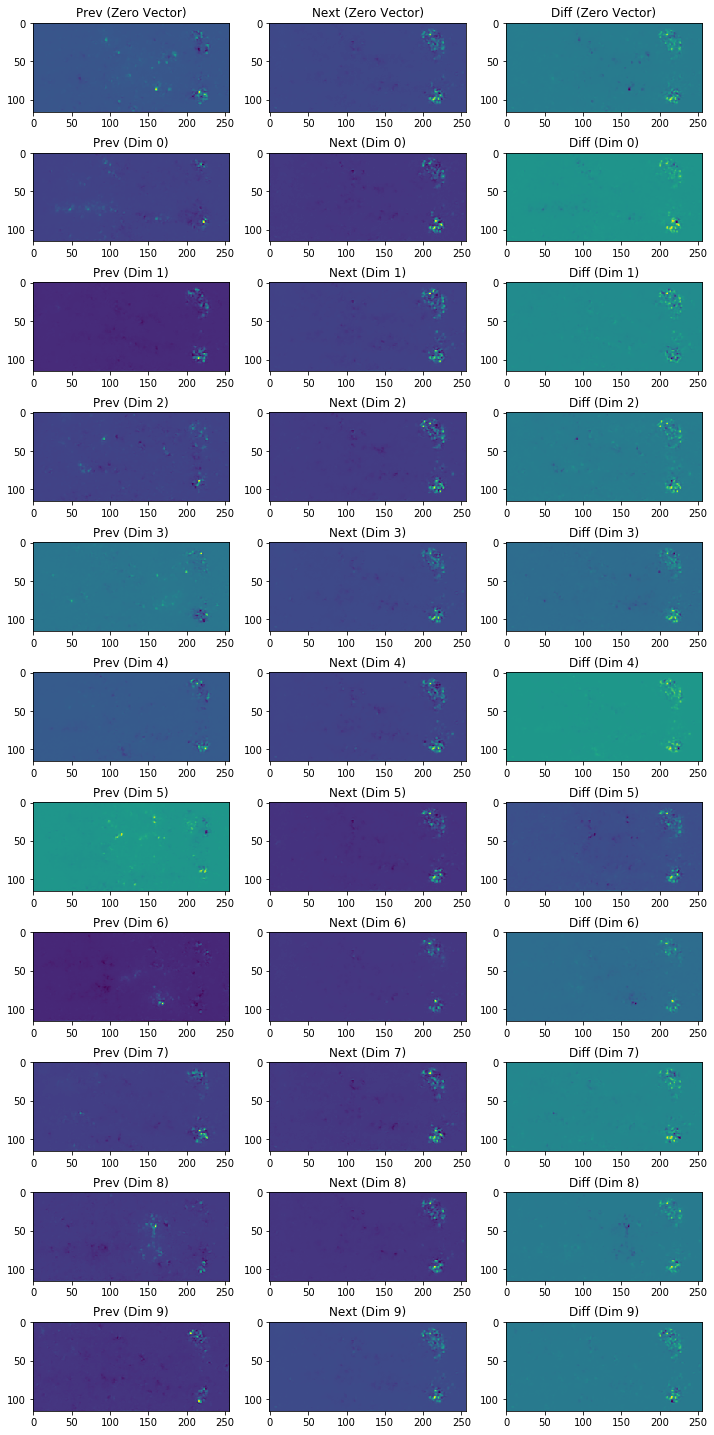

In [28]:
def get_gradient_from_embedding(model,frame,embedding,niters=20, lr=1e-3):
    model.eval()
    frame = frame.cuda()
    frame.requires_grad = True
    embedding_pred, _ = model.encode(frame)
    print(embedding_pred.shape)
    embedding_pred.backward(gradient=embedding)
    return frame.grad[0]

def get_input_from_embedding(model,frame,embedding,niters=75, lr=1e-1, rand=False):
    "Take an embedding vector, and use backprop to find the volume"
    if rand:
        prev_img = T.rand_like(frame[None], requires_grad=True).cuda()
    else:
        prev_img = frame[None].cuda()
        prev_img.requires_grad = True
    optimizer = T.optim.Adam([prev_img],lr=lr)
    model.eval()
    for i in range(niters):
        embedding_pred, _ = model.encode(prev_img)
        loss = F.mse_loss(embedding_pred,embedding[None]) #+ 1e-7*T.norm(prev_img,1)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
#         print("iter {} loss: ".format(i), float(loss))
    model.train()
    return prev_img[0].detach().cpu().numpy()

def interpret(model,prev_vol, next_vol, nEmbedding, prev_func):
    "Plot prev & next frame for each latent dimension"
    plt.figure(figsize=(10,20))
    
    embedding = T.from_numpy(np.zeros(nEmbedding).astype(np.float32)).cuda()[None]
    with T.no_grad():
        prev_img = model.decode(embedding)[0]
        next_img = model.decode(model.predict(embedding))[0]
    plt.subplot(1+nEmbedding,3,1)
    plt.imshow(prev_img[6])
    plt.title("Prev (Zero Vector)")
    plt.subplot(1+nEmbedding,3,2)
    plt.imshow(next_img[6])
    plt.title("Next (Zero Vector)")
    plt.subplot(1+nEmbedding,3,3)
    plt.imshow(next_img[6] - prev_img[6])
    plt.title("Diff (Zero Vector)")
    for i in range(nEmbedding):
        embedding = T.from_numpy(np.eye(nEmbedding)[i].astype(np.float32)).cuda()[None]
        with T.no_grad():
            prev_img = model.decode(embedding)[0]
            next_img = model.decode(model.predict(embedding))[0]
        plt.subplot(1+nEmbedding,3,i*3+4)
        plt.imshow(prev_img[6])
        plt.title("Prev (Dim {})".format(i))
        plt.subplot(1+nEmbedding,3,i*3+5)
        plt.imshow(next_img[6])
        plt.title("Next (Dim {})".format(i))
        plt.subplot(1+nEmbedding,3,i*3+6)
        plt.imshow(next_img[6]-prev_img[6])
        plt.title("Diff (Dim {})".format(i))
    plt.tight_layout()

x, y = data[1000]
interpret(conv_model,x,y,10,get_gradient_from_embedding)

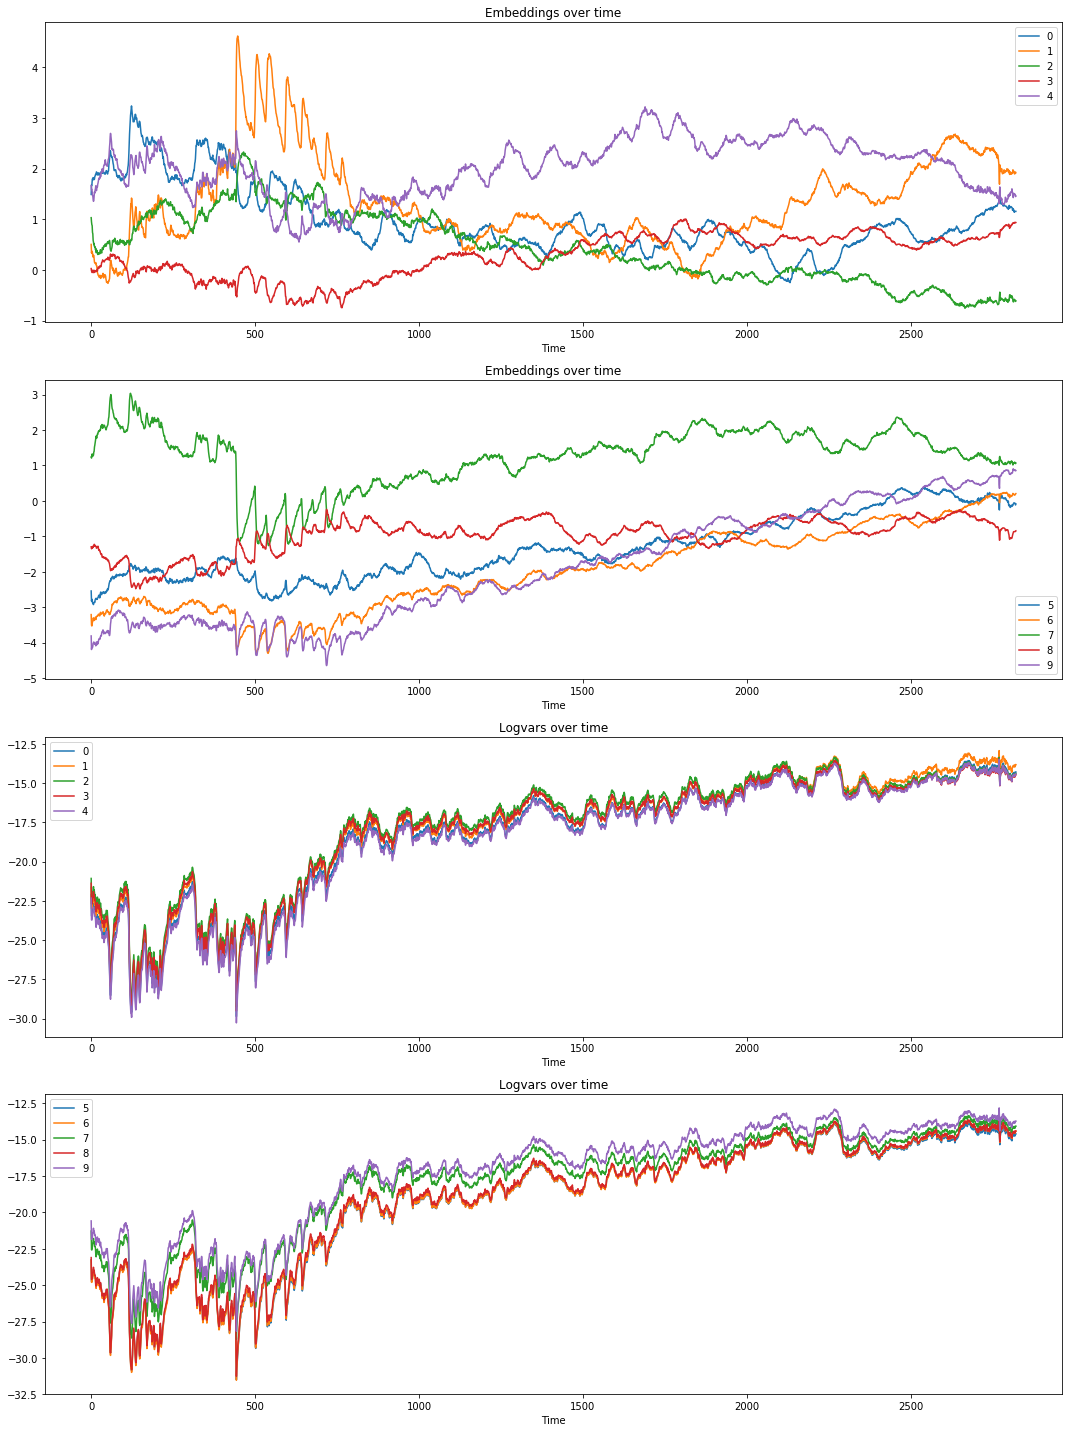

In [29]:
def plot_embedding_over_time(model,data, batch_size=64):
    dataloader = DataLoader(data, batch_size=batch_size, shuffle=False)
    embeddings = []
    logvars = []
    model.eval()
    for batch_data in dataloader:
        X, _ = batch_data
        with T.no_grad():
            embedding, logvar = model.encode(X.cuda())
        embeddings.append(embedding.cpu().numpy())
        logvars.append(logvar.cpu().numpy())
    model.train()
    embeddings = np.vstack(embeddings)
    logvars = np.vstack(logvars)
    nEmbeddings = embeddings.shape[1]
    half = int(np.ceil(nEmbeddings / 2))
    
    plt.figure(figsize=(15,20))
    plt.subplot(4,1,1)
    plt.plot(embeddings[:,0:half])
    plt.title("Embeddings over time")
    plt.xlabel("Time")
    plt.legend(np.arange(half))
    plt.subplot(4,1,2)
    plt.plot(embeddings[:,half:])
    plt.title("Embeddings over time")
    plt.xlabel("Time")
    plt.legend(np.arange(half,nEmbeddings))
    
    plt.subplot(4,1,3)
    plt.plot(logvars[:,0:half])
    plt.title("Logvars over time")
    plt.xlabel("Time")
    plt.legend(np.arange(half))
    plt.subplot(4,1,4)
    plt.plot(logvars[:,half:])
    plt.title("Logvars over time")
    plt.xlabel("Time")
    plt.legend(np.arange(half,nEmbeddings))
    
    plt.tight_layout()
    return embeddings
embeddings = plot_embedding_over_time(conv_model,data)

In [31]:
import skvideo.io
def makePredVideo(model, data, batch_size=32):
    dataloader = DataLoader(data, batch_size=batch_size, shuffle=False)
    writer = skvideo.io.FFmpegWriter(model_name + ".mp4",outputdict={
        '-b': '30000000', '-vcodec': 'libx264'})
    for batch_data in dataloader:
        X, Y = batch_data
        with T.no_grad():
            _, vol_preds, _, _= model(X.cuda())
        for actual,pred in zip(Y,vol_preds):
            # 7th z layer
            f = pred[6]
            H = f.shape[0]
            frame = np.zeros([H*2,f.shape[1]])
            frame[:H] = actual[6,1]
            frame[H:] = pred[6]
            writer.writeFrame(frame)
            
    writer.close()
    return frame, actual[6], pred[6]
frame, actual, pred = makePredVideo(conv_model,data)

In [37]:
def sampleMSE(model,data, batch_size=32):
    dataloader = DataLoader(data, batch_size=batch_size, shuffle=False)
    size = len(data)
    with T.no_grad():
        mse_X = []
        mse_X_pred_to_Y = []
        mse_Y_pred_to_X = []
        mse_X_pred_to_X0 = []
        mse_Y_pred_to_X0 = []
        mse_X_to_Y = []
        mse_Y_to_X0 = []
        mse_X_to_X0 = []
        mse_Y = []
        for batch_data in tqdm(dataloader):
            X, Y = batch_data
            X = X.cuda()
            Y = Y.cuda()
            X_pred, Y_pred, _, _ = model(X)
            
            mse_X.append(volume_mse(X_pred,X[:,:,-1]).cpu())
            mse_X_pred_to_X0.append(volume_mse(X_pred,X[:,:,0]).cpu())
            mse_X_pred_to_Y.append(volume_mse(X_pred,Y[:,:,-1]).cpu())

            mse_Y.append(volume_mse(Y_pred,Y[:,:,-1]).cpu())
            mse_Y_pred_to_X.append(volume_mse(Y_pred,X[:,:,-1]).cpu())
            mse_Y_pred_to_X0.append(volume_mse(Y_pred,X[:,:,0]).cpu())
            
            mse_X_to_Y.append(volume_mse(Y[:,:,-1],X[:,:,-1]).cpu())
            mse_Y_to_X0.append(volume_mse(Y[:,:,-1],X[:,:,0]).cpu())
            mse_X_to_X0.append(volume_mse(X[:,:,-1],X[:,:,0]).cpu())
            
    mse_X = T.cat(mse_X)
    mse_X_pred_to_Y = T.cat(mse_X_pred_to_Y)
    mse_X_pred_to_X0 = T.cat(mse_X_pred_to_X0)
    mse_Y_pred_to_X = T.cat(mse_Y_pred_to_X)
    mse_Y_pred_to_X0 = T.cat(mse_Y_pred_to_X0)
    mse_Y = T.cat(mse_Y)
    mse_Y_to_X0 = T.cat(mse_Y_to_X0)
    mse_X_to_X0 = T.cat(mse_X_to_X0)
    mse_X_to_Y = T.cat(mse_X_to_Y)
    return mse_X, mse_X_pred_to_X0, mse_Y_pred_to_X, mse_X_pred_to_Y, mse_Y, mse_Y_pred_to_X0, mse_X_to_Y, mse_Y_to_X0, mse_X_to_X0

mse_X, mse_X_pred_to_X0, mse_Y_pred_to_X, mse_X_pred_to_Y, mse_Y, mse_Y_pred_to_X0, mse_X_to_Y, mse_Y_to_X0, mse_X_to_X0 = sampleMSE(conv_model, data)

Text(0.5,1,'Distribution of MSE for different timesteps')

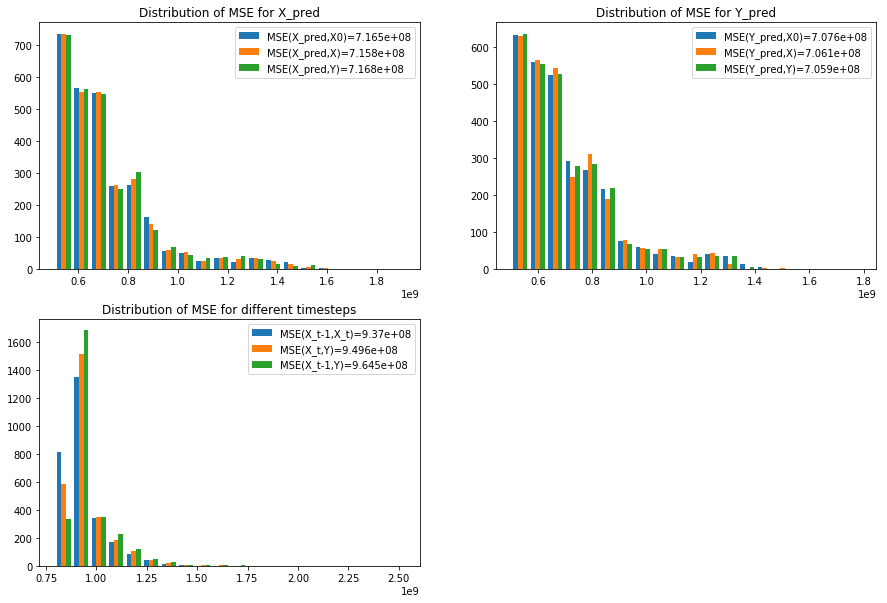

In [41]:
plt.figure(figsize=(15,10))
plt.subplot(2,2,1)
plt.title("Distribution of MSE for X_pred")
plt.hist(T.stack([mse_X_pred_to_X0, mse_X, mse_X_pred_to_Y],1).numpy(),20,fill=True)
plt.legend(["MSE(X_pred,X0)={:.4g}".format(mse_X_pred_to_X0.mean()),
            "MSE(X_pred,X)={:.4g}".format(mse_X.mean()),
            "MSE(X_pred,Y)={:.4g}".format(mse_X_pred_to_Y.mean())])
plt.subplot(2,2,2)
plt.hist(T.stack([mse_Y_pred_to_X0, mse_Y, mse_Y_pred_to_X],1).numpy(),20)
plt.legend(["MSE(Y_pred,X0)={:.4g}".format(mse_Y_pred_to_X0.mean()),
            "MSE(Y_pred,X)={:.4g}".format(mse_Y_pred_to_X.mean()),
            "MSE(Y_pred,Y)={:.4g}".format(mse_Y.mean())])
plt.title("Distribution of MSE for Y_pred")

plt.subplot(2,2,3)
plt.hist(T.stack([mse_X_to_X0, mse_X_to_Y, mse_Y_to_X0],1).numpy(),20)
plt.legend(["MSE(X_t-1,X_t)={:.4g}".format(mse_X_to_X0.mean()),
            "MSE(X_t,Y)={:.4g}".format(mse_Y_to_X.mean()),
            "MSE(X_t-1,Y)={:.4g}".format(mse_Y_to_X0.mean())])
plt.title("Distribution of MSE for different timesteps")

In [115]:
import itertools

In [132]:
def sampleMSE(model,data, batch_size=96):
    prev_frames = data.prev_frames
    next_frames = data.next_frames
    dataloader = DataLoader(data, batch_size=batch_size, shuffle=False)
    xlabels = ['X_t'] + ['X_t-{}'.format(i) for i in range(1,prev_frames)] + ['X_pred']
    ylabels = ['Y_t'] + ['Y_t+{}'.format(i) for i in range(1,next_frames)] + ['Y_pred']
    labels = xlabels+ylabels
    mses = {"MSE({},{})".format(x,y): [] for x,y in itertools.product(labels, labels)}
    size = len(data)
    with T.no_grad():
        for batch_data in tqdm(dataloader):
            X, Y = batch_data
            X = X.cuda()
            Y = Y.cuda()
            X_pred, Y_pred, _, _ = model(X)
            xs = [X[:,:,i] for i in reversed(range(prev_frames))] + [X_pred]
            ys = [Y[:,:,i] for i in range(next_frames)] + [Y_pred]
            dat = xs+ys
            iter = itertools.product(zip(labels,dat), zip(labels,dat))
            for (xlabel, x), (ylabel, y) in iter:
                mse = volume_mse(x,y)
                mses["MSE({},{})".format(xlabel,ylabel)].append(mse)
    mses = {k: T.cat(v).cpu().numpy() for k,v in mses.items()}
    return mses

mses = sampleMSE(conv_model, data)

Text(0.5,1,'Distribution of MSE(X_pred,Y_pred)')

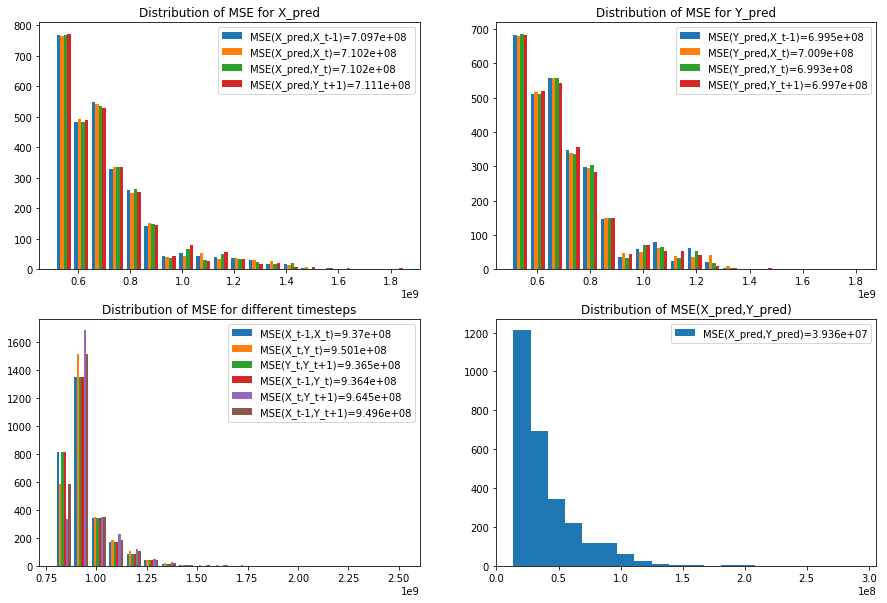

In [136]:
plt.figure(figsize=(15,10))
plt.subplot(2,2,1)
plt.title("Distribution of MSE for X_pred")
labels = ['MSE(X_pred,X_t-1)', 'MSE(X_pred,X_t)', 'MSE(X_pred,Y_t)', 'MSE(X_pred,Y_t+1)']
vals = [mses[k] for k in labels]
plt.hist(np.stack(vals,1), 20)
plt.legend(["{}={:.4g}".format(k,m.mean()) for k, m in zip(labels, vals)])

plt.subplot(2,2,2)
labels = ['MSE(Y_pred,X_t-1)', 'MSE(Y_pred,X_t)', 'MSE(Y_pred,Y_t)', 'MSE(Y_pred,Y_t+1)']
vals = [mses[k] for k in labels]
plt.hist(np.stack(vals,1), 20)
plt.legend(["{}={:.4g}".format(k,m.mean()) for k, m in zip(labels, vals)])
plt.title("Distribution of MSE for Y_pred")

plt.subplot(2,2,3)
labels = ['MSE(X_t-1,X_t)', 'MSE(X_t,Y_t)', 'MSE(Y_t,Y_t+1)',
          'MSE(X_t-1,Y_t)', 'MSE(X_t,Y_t+1)',
          'MSE(X_t-1,Y_t+1)']
vals = [mses[k] for k in labels]
plt.hist(np.stack(vals,1), 20)
plt.legend(["{}={:.4g}".format(k,m.mean()) for k, m in zip(labels, vals)])
plt.title("Distribution of MSE for different timesteps")

plt.subplot(2,2,4)
labels = ['MSE(X_pred,Y_pred)']
vals = [mses[k] for k in labels]
plt.hist(np.stack(vals,1), 20)
plt.legend(["{}={:.4g}".format(k,m.mean()) for k, m in zip(labels, vals)])
plt.title("Distribution of MSE(X_pred,Y_pred)")


In [50]:
scipy.stats.mannwhitneyu(mse_X_to_X0, mse_Y_to_X)

MannwhitneyuResult(statistic=3529128.0, pvalue=6.992093964852082e-14)

In [50]:
scipy.stats.mannwhitneyu(mse_X_to_X0, mse_Y_to_X)

MannwhitneyuResult(statistic=3529128.0, pvalue=6.992093964852082e-14)

In [70]:
scipy.stats.mannwhitneyu(mse_Y_pred_to_X0, mse_Y, alternative='greater')

MannwhitneyuResult(statistic=3986468.0, pvalue=0.46987984760258217)

In [72]:
scipy.stats.mannwhitneyu(mse_X_pred_to_Y, mse_X, alternative='greater')

MannwhitneyuResult(statistic=3992573.5, pvalue=0.4304124535502243)

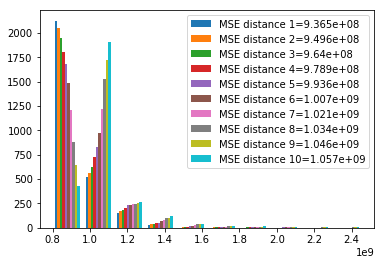

In [94]:
class FishDistanceData(Dataset):
    def __init__(self, imaging, distance):
        data = imaging - imaging.mean(0)
        self.data = T.from_numpy(data)
        self.distance=distance
        
    def __len__(self):
        return self.data.shape[0]-self.distance

    def __getitem__(self, idx):
        return self.data[idx], self.data[idx+self.distance]

def MSEbyDist(imaging, maxdist=10, batch_size=256):
    mse = []
    
    with T.no_grad():
        for d in range(1,maxdist+1):
            data = FishDistanceData(imaging,d)
            dataloader = DataLoader(data, batch_size=batch_size, shuffle=False)
            mse.append([])
            for batch_data in tqdm(dataloader):
                X, Y = batch_data
                X = X.cuda()
                Y = Y.cuda()
                mse[d-1].append(volume_mse(X, Y).cpu())

    mse = [T.cat(m).numpy() for m in mse]
    return mse

mse = MSEbyDist(imaging,10)

plt.hist(mse)
plt.legend(["MSE distance {}={:.4g}".format(d+1,m.mean()) for d, m in enumerate(mse)])

In [110]:
scipy.stats.mannwhitneyu(mse[0], mse[1], alternative='two-sided')

MannwhitneyuResult(statistic=3536209.5, pvalue=1.509944087245247e-13)